# Pulse Shuttling

This tutorial will show how to use the shuttling module to generate shuttling pulses, find the time evolution of the wave function, and calculate the adiabaticity over time.

## 1. Load relevant modules and add the current location to path

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))
import qudipy as qd
import numpy as np
import qudipy.potential as pot
from qudipy.shuttling.real_space import *

## 2. Load preprocessed potential files

We need to specify the folder that contains the preprocess potential files and the control voltage names to load them into a dictionary. Then, we can find the potential interpolator object.

In [2]:
# Load preprocessed potential files from the potentail folder
pot_dir = os.path.dirname(os.getcwd()) + '/qudipy/potential/Sliced_potentials/'
    
# Specify the control voltage names (C#NAME as mentioned above)
ctrl_names = ['V1','V2','V3','V4','V5']

# Specify the control voltage values you wish to load.
# The cartesian product of all these supplied voltages will be loaded and MUST exist in the directory.
V1 = [0.1]
V2 = [0.2, 0.22, 0.24, 0.26, 0.27, 0.28]
V3 = [0.2, 0.22, 0.24, 0.26, 0.27, 0.28]
V4 = [0.2, 0.22, 0.24, 0.26, 0.27, 0.28]
V5 = [0.1]
# Add all voltage values to a list
ctrl_vals = [V1, V2, V3, V4, V5]    

# Now load the potentials.  
# load_files returns a dictionary of all the information loaded
loaded_data = pot.load_potentials(ctrl_vals, ctrl_names, f_type='pot', 
                              f_dir=pot_dir, f_pot_units="eV", 
                              f_dis_units="nm")

# Now building the interpolator object is trivial
pot_interp = pot.build_interpolator(loaded_data, 
                                             constants=qd.Constants("Si/SiO2"),y_slice= 0)

## 3. Building a shuttling pulse

An 3-dot electron shuttling pulse from the first dot to the third dot can be built by starting with the max voltage at the first dot. Then, the second voltage is raised to resonant tunneling coupling frequency, and the first voltage is reduced to minimum voltage. Next, the third voltage is is raised to resonant tunneling coupling frequency, and the second voltage is reduced to minimum voltage.

Users can define the starting minimum and maximum voltages, the total pulse length, and the potential interpolator found with the loaded potential files. The argument *plot_pulse* allows users to plot the shuttling pulse built.

The pulses are shaped in a way that whenever a change in voltage happens, 96.5% of the change is done in 1/20 of the total pulse time, and the rest of the pulse is interpolated linearly.

In [3]:
# Initial voltages in volts
min_v = 0.2
max_v = 0.278

# Shuttling pulse in picoseconds
pulse_length = 1

# Build the pulse

# Define the pulse with 9 points
pt1 = [max_v, min_v, min_v]
# pot_interp.plot(pt1, plot_type='1D', show_wf=True)

vv = pot_interp.find_resonant_tc(pt1, 1)
most_vv = vv - 0.035 * (max_v - min_v)
pt2 = pt1.copy()
pt2[1] = most_vv

pt3 = pt2.copy()
pt3[1] = vv

pt4 = pt3.copy()
pt4[0] = most_vv

pt5 = pt4.copy()
pt5[0] = min_v

vv = pot_interp.find_resonant_tc(pt5, 2)
most_vv = vv - 0.035 * (max_v - min_v)
pt6 = pt5.copy()
pt6[2] = most_vv

pt7 = pt6.copy()
pt7[2] = vv

pt8 = pt7.copy()
pt8[1] = most_vv

pt9 = pt8.copy()
pt9[1] = min_v

shuttle_pulse = np.array([pt1, pt2, pt3, pt4, pt5, pt6, pt7, pt8, pt9])

shut_pulse = qd.circuit.ControlPulse('shuttle_test', 'experimental', 
                                    pulse_length=pulse_length)
shut_pulse.add_control_variable('V2',shuttle_pulse[:,0])
shut_pulse.add_control_variable('V3',shuttle_pulse[:,1])
shut_pulse.add_control_variable('V4',shuttle_pulse[:,2])
ctrl_time_L = pulse_length * np.array([0, 1/20, 1/4, 1/2-1/20, 1/2, 1/2+1/20, 3/4, 19/20, 1])
shut_pulse.add_control_variable('time',ctrl_time_L)

/Users/keweizhou/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/keweizhou/Google_Drive/Research/20summer/Waterloo/QuDiPy/qudipy/potential/potentialinterpolator.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  volt_vec = list(np.array(volt_vec_input).T)


You can plot the shuttling pulse by running the code below.

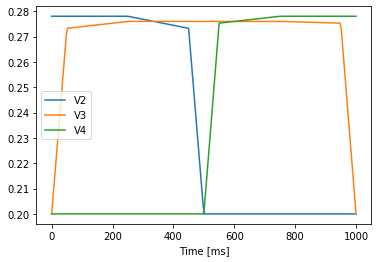

In [4]:
shut_pulse.plot()

## 4. Evolving over time

When supplied with the pulses we built above, the wave function would evolve over time. We use the split operator method to calculate this evolution. We iterate over time steps of $5 * 10^{-16}$ seconds. At each time step, we update the potential resulted from the interpolated pulse. We would result in a new wave function at the end of the evolution, which is supplied as the initial wave function to the next iteration.

This module provides two ways to visualize this evolution: animation and adiabaticity plot. For the animation, it shows both the evolution of the potential and that of the wavefunction. We can specify how often we update the frame using the the *animation_res* argument. For the adiabaticity, we calculate the inner product between the current state and the ground state of the current potential every couple time steps. The resolution is determined by the *adiabaticity_res* argument, which means how many points in total we calculate. All the calculated adiabaticity data are saved to a .csv file.

Note: the animation cannot be shown in jupyter notebook. It has to be run as a python file.

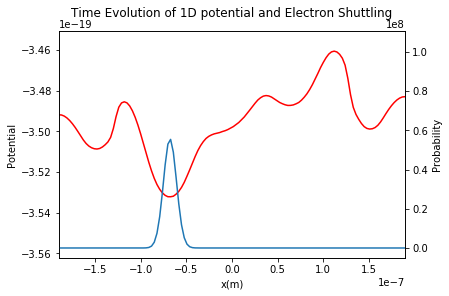

0.0 0.9999997258127419
0.002001000500250125 0.9999995933921537
0.00400200100050025 0.9999993111764964
0.006003001500750374 0.9999986728364425
0.0080040020010005 0.9999973391795677
0.010005002501250625 0.9999948375071541
0.012006003001500749 0.9999905600558784
0.014007003501750874 0.9999837623421617
0.016008004002001 0.9999735570078102
0.018009004502251125 0.9999589112720894
0.02001000500250125 0.9999386500024814
0.022011005502751375 0.999911455079704
0.024012006003001497 0.9998758673762437
0.026013006503251623 0.9998302882237728
0.028014007003501748 0.9997729843943878
0.030015007503751873 0.9997022140642619
0.032016008004002 0.9996160835637605
0.03401700850425212 0.9995125229171341
0.03601800900450225 0.9993893301313854
0.03801900950475237 0.999244173148943
0.0400200100050025 0.9990745928138902
0.04202101050525262 0.9988780097765
0.04402201100550275 0.9986517588087693
0.04602301150575287 0.9983930317354088
0.048024012006002995 0.9980988861951329


<Figure size 432x288 with 0 Axes>

0.05002501250625312 0.9977659997369585
0.052026013006503245 0.9973968027229456
0.054027013506753374 0.99699934900228
0.056028014007003496 0.9965736583828528
0.058029014507253625 0.9961197562851386
0.06003001500750375 0.9956376744883902
0.062031015507753876 0.9951274511776609
0.064032016008004 0.9945891302486723
0.06603301650825412 0.9940227600906602
0.06803401700850424 0.9934283922469981
0.07003501750875438 0.992806080385416
0.0720360180090045 0.9921558798871898
0.07403701850925462 0.9914778481386879
0.07603801900950474 0.9907720453654337
0.07803901950975488 0.9900385356767407
0.080040020010005 0.9892773879451973
0.08204102051025512 0.988488676236991
0.08404202101050524 0.9876724796936953
0.08604302151075537 0.9868288819705695
0.0880440220110055 0.9859579704852153
0.09004502251125562 0.9850598357743076
0.09204602301150575 0.9841345711872761
0.09404702351175587 0.9831822729985626
0.09604802401200599 0.9822030408547467
0.09804902451225612 0.9811969783521389


<Figure size 432x288 with 0 Axes>

0.10005002501250625 0.9801641935060026
0.10205102551275637 0.9791047989311097
0.10405202601300649 0.9780189116763156
0.10605302651325663 0.9769066527923878
0.10805402701350675 0.975768146809581
0.11005502751375687 0.974603521324518
0.11205602801400699 0.9734129068401715
0.11405702851425711 0.9721964368940994
0.11605802901450725 0.9709542483934895
0.11805902951475737 0.9696864819972152
0.1200600300150075 0.9683932823741542
0.12206103051525762 0.9670747982250044
0.12406203101550775 0.9657311820560369
0.12606303151575787 0.964362589795335
0.128064032016008 0.9629691804038234
0.13006503251625812 0.9615511156307429
0.13206603301650824 0.9601085599988008
0.13406703351675836 0.9586416810059007
0.13606803401700848 0.957150649439371
0.13806903451725863 0.9556356396526933
0.14007003501750875 0.9540968296724934
0.14207103551775888 0.9525344010769237
0.144072036018009 0.9509485386843181
0.14607303651825912 0.9493394301717321
0.14807403701850924 0.9477072657724963


<Figure size 432x288 with 0 Axes>

0.15007503751875936 0.9460522381677525
0.15207603801900949 0.94437454260343
0.1540770385192596 0.9426743771667969
0.15607803901950976 0.9409519430871168
0.15807903951975988 0.9392074449130683
0.16008004002001 0.937441090471091
0.16208104052026012 0.9356530906021973
0.16408204102051024 0.933843658770282
0.16608304152076037 0.9320130106915946
0.1680840420210105 0.930161364127829
0.1700850425212606 0.9282889389165245
0.17208604302151073 0.926395957210921
0.17408704352176088 0.9244826438103615
0.176088044022011 0.9225492264211799
0.17808904452226113 0.9205959357151396
0.18009004502251125 0.9186230051373527
0.18209104552276137 0.9166306705223022
0.1840920460230115 0.9146191696597541
0.1860930465232616 0.9125887419757275
0.18809404702351173 0.9105396284465848
0.19009504752376186 0.9084720717660238
0.19209604802401198 0.9063863166768272
0.19409704852426213 0.9042826103077465
0.19609804902451225 0.9021612023518603
0.19809904952476237 0.9000223449883741


<Figure size 432x288 with 0 Axes>

0.2001000500250125 0.8978662925577344
0.20210105052526262 0.8956933011043379
0.20410205102551274 0.8935036279576563
0.20610305152576286 0.8912975315069949
0.20810405202601298 0.8890752712439145
0.2101050525262631 0.886837108033782
0.21210605302651325 0.884583304481706
0.21410705352676337 0.8823141252187455
0.2161080540270135 0.8800298369681211
0.21810905452726362 0.8777307083435767
0.22011005502751374 0.8754170094437609
0.22211105552776386 0.8730890113905974
0.22411205602801398 0.8707469859811914
0.2261130565282641 0.8683912055737624
0.22811405702851423 0.8660219432298141
0.23011505752876438 0.8636394730289139
0.2321160580290145 0.861244070403042
0.23411705852926462 0.8588360123324013
0.23611805902951474 0.8564155773045088
0.23811905952976486 0.8539830450371102
0.240120060030015 0.8515386960614107
0.2421210605302651 0.8490828113162826
0.24412206103051523 0.846615671895453
0.24612306153076535 0.844137559023874
0.2481240620310155 0.8416487542449764


<Figure size 432x288 with 0 Axes>

0.2501250625312656 0.8391495397165027
0.25212606303151575 0.8366403024142385
0.25412706353176584 0.8341214604622278
0.256128064032016 0.8315932993597573
0.25812906453226614 0.8290561049298523
0.26013006503251623 0.8265101629420321
0.2621310655327664 0.8239557587912082
0.2641320660330165 0.8213931773367098
0.2661330665332666 0.8188227029391327
0.2681340670335167 0.816244619654439
0.27013506753376687 0.813659211485507
0.27213606803401696 0.8110667625732074
0.2741370685342671 0.8084675572372189
0.27613806903451726 0.8058618798382959
0.27813906953476736 0.803250014503503
0.2801400700350175 0.8006322448070134
0.2821410705352676 0.7980088535127344
0.28414207103551775 0.7953801224576179
0.28614307153576785 0.7927463325980812
0.288144072036018 0.7901077641789889
0.2901450725362681 0.7874646969391895
0.29214607303651824 0.7848174102563459
0.2941470735367684 0.7821661831598605
0.2961480740370185 0.7795112941931529
0.29814907453726863 0.7768530211648246


<Figure size 432x288 with 0 Axes>

0.3001500750375187 0.7741916408700001
0.3021510755377689 0.771527428872988
0.30415207603801897 0.7688606594171201
0.3061530765382691 0.7661916054776532
0.3081540770385192 0.7635205389184365
0.31015507753876936 0.7608477306739575
0.3121560780390195 0.7581734508702331
0.3141570785392696 0.7554979688235267
0.31615807903951976 0.752821552904736
0.31815907953976985 0.7501444703101935
0.32016008004002 0.7474669868158615
0.3221610805402701 0.744789366597399
0.32416208104052024 0.742111872171542
0.32616308154077034 0.7394347644655884
0.3281640820410205 0.7367583029710859
0.33016508254127064 0.7340827459051281
0.33216608304152073 0.7314083503009569
0.3341670835417709 0.7287353719790791
0.336168084042021 0.7260640653988972
0.3381690845422711 0.7233946834389886
0.3401700850425212 0.7207274771824943
0.34217108554277137 0.7180626957812272
0.34417208604302146 0.715400586439645
0.3461730865432716 0.7127413945111484
0.34817408704352176 0.7100853636540638


<Figure size 432x288 with 0 Axes>

0.35017508754377186 0.7074327359714425
0.352176088044022 0.704783752066593
0.3541770885442721 0.7021386509816364
0.35617808904452225 0.6994976700345943
0.35817908954477234 0.6968610446119378
0.3601800900450225 0.6942290079912238
0.3621810905452726 0.6916017912555419
0.36418209104552274 0.6889796233234535
0.3661830915457729 0.6863627310707906
0.368184092046023 0.6837513394834959
0.37018509254627313 0.6811456717688638
0.3721860930465232 0.6785459493706427
0.3741870935467734 0.6759523918739214
0.37618809404702347 0.6733652168315927
0.3781890945472736 0.670784639576601
0.3801900950475237 0.6682108730897159
0.38219109554777386 0.665644127969171
0.38419209604802396 0.6630846125059987
0.3861930965482741 0.6605325328251117
0.38819409704852426 0.6579880930253167
0.39019509754877435 0.6554514952527357
0.3921960980490245 0.6529229396707692
0.3941970985492746 0.6504026243337403
0.39619809904952474 0.647890745012016
0.39819909954977484 0.6453874950367258


<Figure size 432x288 with 0 Axes>

0.400200100050025 0.6428930652236086
0.4022011005502751 0.6404076439018754
0.40420210105052523 0.6379314170295862
0.4062031015507754 0.6354645683408352
0.4082041020510255 0.6330072794573427
0.4102051025512756 0.6305597299130701
0.4122061030515257 0.6281220970782023
0.41420710355177587 0.6256945560120011
0.41620810405202596 0.6232772793041692
0.4182091045522761 0.6208704369687219
0.4202101050525262 0.6184741964314511
0.42221110555277636 0.6160887226118968
0.4242121060530265 0.6137141780608759
0.4262131065532766 0.6113507230919258
0.42821410705352675 0.6089985158490185
0.43021510755377684 0.6066577122812962
0.432216108054027 0.6043284660357668
0.4342171085542771 0.6020109283135607
0.43621810905452724 0.5997052477497428
0.43821910955477733 0.5974115703654136
0.4402201100550275 0.595130039609283
0.44222111055527763 0.5928607964681629
0.4442221110555277 0.5906039795980377
0.4462231115557779 0.5883597254207612
0.44822411205602797 0.5861281681480645


<Figure size 432x288 with 0 Axes>

0.4502251125562781 0.5839094397263379
0.4522261130565282 0.5816817039288146
0.45422711355677836 0.5794202032240761
0.45622811405702846 0.5771221423299786
0.4582291145572786 0.5747874002842445
0.46023011505752875 0.5724159312762567
0.46223111555777885 0.5700083080591348
0.464232116058029 0.5675644362491106
0.4662331165582791 0.565084040805874
0.46823411705852924 0.5625668089722453
0.47023511755877934 0.5600123904069525
0.4722361180590295 0.5574203988316144
0.4742371185592796 0.5547903591704705
0.47623811905952973 0.5521216297002108
0.4782391195597799 0.5494137416851351
0.48024012006003 0.546666221274455
0.4822411205602801 0.5438785756294854
0.4842421210605302 0.5410502943088099
0.48624312156078037 0.5381808502991623
0.48824412206103046 0.535269709568219
0.4902451225612806 0.5323163150728495
0.4922461230615307 0.5293200680023017
0.49424712356178085 0.5262803594543127
0.496248124062031 0.5231965744053301
0.4982491245622811 0.5200680954887936


<Figure size 432x288 with 0 Axes>

0.5002501250625312 0.5168943066830496
0.5022511255627814 0.5136908817346949
0.5042521260630315 0.5104740969398934
0.5062531265632816 0.5072442523295024
0.5082541270635317 0.5040016489922898
0.5102551275637819 0.5007465884454669
0.512256128064032 0.4974793723350336
0.5142571285642821 0.4942003307420587
0.5162581290645323 0.49091010137273067
0.5182591295647824 0.4876090193066993
0.5202601300650325 0.48429732215386345
0.5222611305652826 0.4809752499522372
0.5242621310655328 0.4776430451945364
0.5262631315657829 0.47430095263899125
0.528264132066033 0.4709491831811821
0.530265132566283 0.4675879277005336
0.5322661330665333 0.46421750806322537
0.5342671335667833 0.46083825275499707
0.5362681340670334 0.4574504907288868
0.5382691345672836 0.45405455142131523
0.5402701350675337 0.4506507646062005
0.5422711355677838 0.4472374729988346
0.5442721360680339 0.44381352081037545
0.5462731365682841 0.440379159338855
0.5482741370685342 0.4369353600754581


<Figure size 432x288 with 0 Axes>

0.5502751375687843 0.43348408279287154
0.5522761380690345 0.4300333424783369
0.5542771385692846 0.426590786604991
0.5562781390695347 0.42315681263576255
0.5582791395697848 0.41973180860367293
0.560280140070035 0.4163161531884821
0.5622811405702851 0.4129102155886283
0.5642821410705352 0.40951435523966523
0.5662831415707853 0.40612892147643953
0.5682841420710355 0.40275425325380226
0.5702851425712856 0.39939067902478814
0.5722861430715357 0.396038516831079
0.5742871435717859 0.3926980746014485
0.576288144072036 0.3893696505972493
0.5782891445722861 0.38605353390610697
0.5802901450725362 0.38275000487641914
0.5822911455727864 0.37945933540784554
0.5842921460730365 0.3761817890592394
0.5862931465732866 0.37291762099104875
0.5882941470735368 0.3696670778069902
0.5902951475737869 0.3664303973852317
0.592296148074037 0.36320780878520154
0.5942971485742871 0.35999953228474535
0.5962981490745373 0.356805779555092
0.5982991495747874 0.35362675393456405


<Figure size 432x288 with 0 Axes>

0.6003001500750375 0.35046265073239097
0.6023011505752875 0.3473136574913275
0.6043021510755378 0.3441799541621499
0.6063031515757878 0.3410617131845072
0.6083041520760379 0.33795909951058767
0.6103051525762881 0.3348722706339593
0.6123061530765382 0.33180137668526405
0.6143071535767883 0.32874656062931207
0.6163081540770384 0.32570795855520696
0.6183091545772886 0.32268570000982894
0.6203101550775387 0.31967990830237153
0.6223111555777888 0.316690700713585
0.624312156078039 0.31371818857637596
0.6263131565782891 0.3107624772419115
0.6283141570785392 0.30782366598867683
0.6303151575787893 0.3049018479537077
0.6323161580790395 0.30199711015665565
0.6343171585792896 0.29910953365175547
0.6363181590795397 0.2962391937944283
0.6383191595797898 0.29338616056748296
0.64032016008004 0.29055049889311113
0.6423211605802901 0.28773226886795716
0.6443221610805402 0.2849315258938051
0.6463231615807904 0.28214832072040885
0.6483241620810405 0.2793826994508767


<Figure size 432x288 with 0 Axes>

0.6503251625812906 0.27663470356984105
0.6523261630815407 0.2739043700371261
0.6543271635817909 0.2711917314535615
0.656328164082041 0.26849681626782873
0.6583291645822911 0.2658196489712897
0.6603301650825413 0.263160250231936
0.6623311655827914 0.26051863694740757
0.6643321660830415 0.25789482223751875
0.6663331665832916 0.2552888154302537
0.6683341670835418 0.25270062210544086
0.6703351675837919 0.2501302442409051
0.672336168084042 0.24757768046347556
0.674337168584292 0.24504292635913255
0.6763381690845423 0.24252597476370244
0.6783391695847923 0.24002681595338407
0.6803401700850424 0.23754543768613023
0.6823411705852926 0.23508182509960762
0.6843421710855427 0.23263596052789923
0.6863431715857928 0.23020782333449785
0.6883441720860429 0.22779738985823741
0.6903451725862931 0.22540463353051354
0.6923461730865432 0.2230295251601204
0.6943471735867933 0.22067203331962437
0.6963481740870435 0.21833212472817826
0.6983491745872936 0.21600976452502804


<Figure size 432x288 with 0 Axes>

0.7003501750875437 0.2137049163658961
0.7023511755877938 0.21141754233662305
0.704352176088044 0.20914760274160277
0.7063531765882941 0.2068950558655911
0.7083541770885442 0.2046598578123102
0.7103551775887943 0.20244196249169472
0.7123561780890445 0.20024132177287515
0.7143571785892946 0.19805788576296443
0.7163581790895447 0.1958916031327415
0.7183591795897949 0.19374242140163864
0.720360180090045 0.1916102871162056
0.7223611805902951 0.1894951458976248
0.7243621810905452 0.1873969423780946
0.7263631815907954 0.18531562007721725
0.7283641820910455 0.18325112127887858
0.7303651825912956 0.18120338695682991
0.7323661830915458 0.17917235677144874
0.7343671835917959 0.17715796913284354
0.736368184092046 0.17516016130678272
0.7383691845922961 0.17317886953472722
0.7403701850925463 0.17121402914602343
0.7423711855927964 0.16926557465280515
0.7443721860930465 0.1673334398291725
0.7463731865932965 0.16541755778075823
0.7483741870935467 0.16351786100817214


<Figure size 432x288 with 0 Axes>

0.7503751875937968 0.1616342814612434
0.7523761880940469 0.15976683981665107
0.7543771885942971 0.15791553510936163
0.7563781890945472 0.1560802958644977
0.7583791895947973 0.1542610499603529
0.7603801900950474 0.15245772457140844
0.7623811905952976 0.1506702461190728
0.7643821910955477 0.14889854024778787
0.7663831915957978 0.14714253183776843
0.7683841920960479 0.14540214505695942
0.7703851925962981 0.14367730344718918
0.7723861930965482 0.14196793003508654
0.7743871935967983 0.14027394745712762
0.7763881940970485 0.13859527808840463
0.7783891945972986 0.1369318441641583
0.7803901950975487 0.13528356788081775
0.7823911955977988 0.13365037146031955
0.784392196098049 0.1320321771607655
0.7863931965982991 0.1304289072211948
0.7883941970985492 0.1288404837399201
0.7903951975987994 0.12726682850289314
0.7923961980990495 0.12570786279612717
0.7943971985992996 0.12416350724779145
0.7963981990995497 0.12263368174554552
0.7983991995997999 0.12111830546074044


<Figure size 432x288 with 0 Axes>

0.80040020010005 0.11961729698584282
0.8024012006003001 0.1181305745617953
0.8044022011005502 0.11665805634715153
0.8064032016008004 0.11519966066879357
0.8084042021010505 0.11375530619896908
0.8104052026013006 0.11232491202384734
0.8124062031015508 0.11090839759834069
0.8144072036018009 0.10950568261135839
0.816408204102051 0.10811668680618038
0.818409204602301 0.10674132980682913
0.8204102051025512 0.10537953099259859
0.8224112056028013 0.10403120944339678
0.8244122061030514 0.10269628395523529
0.8264132066033016 0.10137467310546279
0.8284142071035517 0.10006629533654844
0.8304152076038018 0.09877106902749082
0.8324162081040519 0.09748891253181462
0.8344172086043021 0.09621974417664353
0.8364182091045522 0.09496348223338784
0.8384192096048023 0.09372004488237577
0.8404202101050524 0.09248935019797509
0.8424212106053026 0.0912713161761144
0.8444222111055527 0.0900658608136245
0.8464232116058028 0.08887290223152976
0.848424212106053 0.0876923588169767


<Figure size 432x288 with 0 Axes>

0.8504252126063031 0.08652414934619405
0.8524262131065532 0.08536819304844294
0.8544272136068033 0.08422440958088848
0.8564282141070535 0.08309271890582366
0.8584292146073036 0.08197304108985608
0.8604302151075537 0.0808652960714667
0.8624312156078039 0.07976940345964897
0.864432216108054 0.07868528242498894
0.8664332166083041 0.07761285172337487
0.8684342171085542 0.07655202985591808
0.8704352176088044 0.07550273532709834
0.8724362181090545 0.07446488693014609
0.8744372186093046 0.07343840397631667
0.8764382191095547 0.07242320639897985
0.8784392196098049 0.07141921470140633
0.880440220110055 0.07042634976718382
0.882441220610305 0.06944453259757817
0.8844422211105553 0.0684736840648032
0.8864432216108054 0.06751372476461605
0.8884442221110554 0.06656457501694389
0.8904452226113055 0.06562615501102557
0.8924462231115557 0.06469838504018871
0.8944472236118058 0.06378118573942017
0.8964482241120559 0.06287447823814138
0.8984492246123061 0.06197818417163121


<Figure size 432x288 with 0 Axes>

0.9004502251125562 0.06109222554624306
0.9024512256128063 0.060216524507158
0.9044522261130564 0.059351003093363865
0.9064532266133066 0.05849558306981385
0.9084542271135567 0.05765018589958231
0.9104552276138068 0.0568147328694701
0.9124562281140569 0.055989145329043415
0.9144572286143071 0.05517334496476629
0.9164582291145572 0.05436725402095474
0.9184592296148073 0.053570795400246556
0.9204602301150575 0.05278389261941729
0.9224612306153076 0.05200646964531764
0.9244622311155577 0.05123845067292382
0.9264632316158078 0.050479759920687664
0.928464232116058 0.04973032150479056
0.9304652326163081 0.04899005942062377
0.9324662331165582 0.04825889762046404
0.9344672336168084 0.0475367601454745
0.9364682341170585 0.046823571257878435
0.9384692346173086 0.04611925552761161
0.9404702351175587 0.04542373785125516
0.9424712356178089 0.04473694340897417
0.944472236118059 0.04405879758663357
0.9464732366183091 0.04338922589824724
0.9484742371185592 0.04272815393758541


<Figure size 432x288 with 0 Axes>

0.9504752376188094 0.04207550737195171
0.9524762381190595 0.04143927870349459
0.9544772386193096 0.04082421138834351
0.9564782391195598 0.04022975250813314
0.9584792396198099 0.03965543884346273
0.96048024012006 0.039100841673992484
0.96248124062031 0.0385654403329799
0.9644822411205602 0.03804873601805531
0.9664832416208103 0.03755031875766924
0.9684842421210604 0.037069785898071375
0.9704852426213106 0.03660674247134584
0.9724862431215607 0.036160801484244026
0.9744872436218108 0.03573162065850617
0.9764882441220609 0.03531918260330336
0.9784892446223111 0.03492319870737444
0.9804902451225612 0.034543305967393065
0.9824912456228113 0.03417914969749159
0.9844922461230614 0.03383038353721787
0.9864932466233116 0.03349666943379631
0.9884942471235617 0.03317754170423522
0.9904952476238118 0.032872367913064734
0.992496248124062 0.032580832331383425
0.9944972486243121 0.03230264006063859
0.9964982491245622 0.0320375037952571
0.9984992496248123 0.031785143444319625
Time:  4.584659263000001


In [5]:
time_evolution(pot_interp, shut_pulse, show_animation = True, save_data = True)

## 5. Plotting adiabaticity

We can plot adiabaticity of pulses with different pulse lengths on the same plot. Note that the x-axis is nondimensionalized. It represents fraction of the total pulse length rather than the actual time.

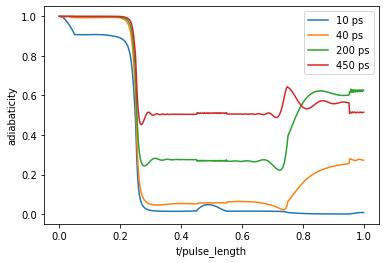

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("adiabaticity.csv") 

for pulse_length in [10, 40, 200, 450]:
    time_orig = list(df[df['pulse_length'] == pulse_length]['time'])
    time = [t/pulse_length for t in time_orig]
    adiabaticity = list(df[df['pulse_length'] == pulse_length]['adiabaticity'])
    plt.plot(time,adiabaticity, label = '{} ps'.format(pulse_length))

plt.xlabel('t/pulse_length')
plt.ylabel('adiabaticity')
plt.legend()
plt.show()